# QOSF mentorship program screening task 	

# Name: Bao Bach
# Email: bao.bachbbace12@hcmut.edu.vn


# Task 2: Solution

## I. Libraries 

In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_state_qsphere
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
import numpy as np
from numpy import random

## II. Bit-flip code and the sign-flip code

### 1. Introduction to Quantum Error Correction (QEC)
As we have known, the basis components of a quantum computer are fragile, because they are really small. They are easily affected by only a minor influence such as a weak magnetic field, or a dim light beam. Therefore, **QEC** (quantum error correction) which is concerned with correcting unwanted errors in the behaviour of quantum machinery, is required to increase the stability of a quantum computer or a quantum system. 
There are two basic type of errors is the **bit-flip code** (X-gate) and **sign-flip code** (Z-gate), each has their own ways to detect the error and fix it.

### 2. The initial state of our system
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$
According to the circuit which has been provided, we have our default state is: $\ket{0} \otimes \ket{0}$, after apply H-gate to the first qubit we get: $(\frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}) \otimes \ket{0}$, finally apply the CNOT-gate with the first qubit as the control qubit and the second qubit as the target qubit: $\frac{1}{\sqrt{2}}\ket{00} + \frac{1}{\sqrt{2}}\ket{11}$ which is the Bell state.
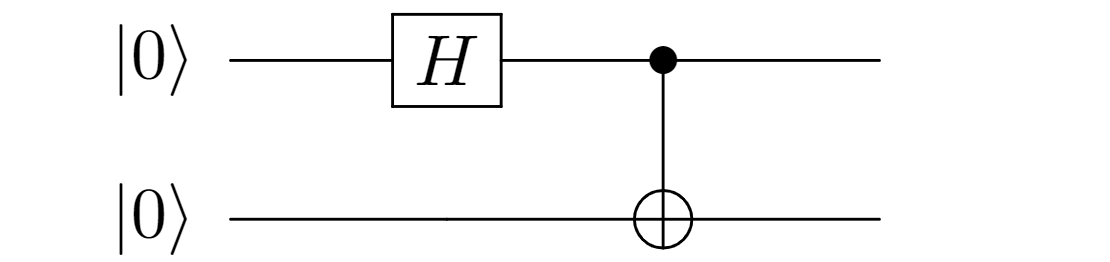 


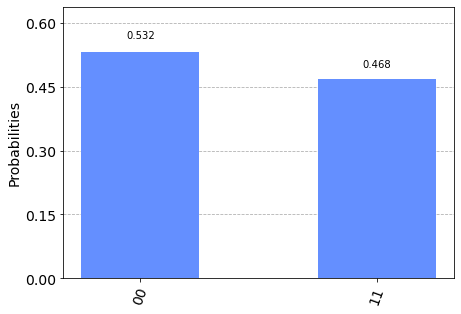

In [2]:
q = QuantumRegister(2,'q')
c = ClassicalRegister(2,'c')
qcb = QuantumCircuit(q,c)

qcb.h(q[0])
qcb.cnot(q[0],q[1])
qcb.measure(q[0],c[0])
qcb.measure(q[1],c[1])

counts = execute(qcb, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

### 3. Custom noise model 
For this task, our concerns are the bit-flip and phase-flip which are occured when we apply gate-X and gate-Z to the circuit. Therefore, I customize a noise model with the help from this link: <https://qiskit.org/documentation/apidoc/aer_noise.html>

In [3]:
def get_noise(p_gate):
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = depolarizing_error(p_gate, 1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["z"]) # single qubit gate error is applied to z gates
    return noise_model

In [4]:
noise_model = get_noise(0.05) #I create a noise_model with p_gate= 0.05

### 4. Bit-flip code
The bit-flip code is the error when we apply the X-gate to the circuit and the result is opposite to our expected value.

**Example**: When we apply the X-gate to qubit with state $\ket{0}$, the expected value is state $\ket{1}$ but the error may occured and our result is state $\ket{1}$

According to the task, our initial state is a bell state which is: $\frac{1}{\sqrt{2}}\ket{00} + \frac{1}{\sqrt{2}}\ket{11}$
If there is no noise and errors in our system, when we apply X-gate to one of the two qubits, we should get the state: $\frac{1}{\sqrt{2}}\ket{01} + \frac{1}{\sqrt{2}}\ket{10}$. However due to the noise, we can get states $\ket{00}$ and $\ket{11}$

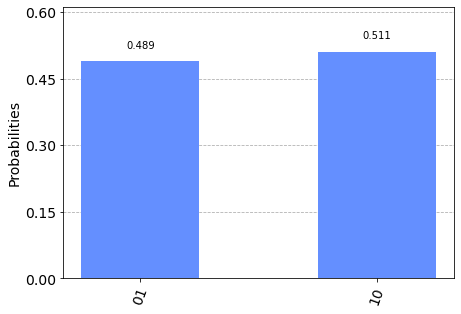

In [5]:
q = QuantumRegister(2,'q')
c = ClassicalRegister(2,'c')
qc0 = QuantumCircuit(q,c)

qc0.h(q[0])
qc0.cnot(q[0],q[1])
qc0.x(q[1])

qc0.measure(q[0],c[0])
qc0.measure(q[1],c[1])
counts = execute(qc0, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

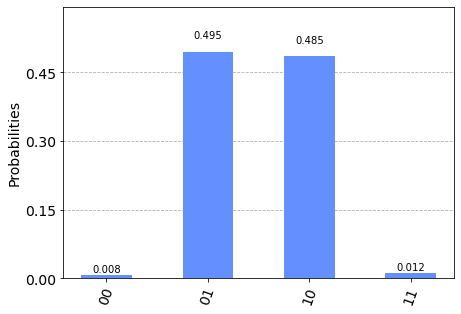

In [6]:
counts = execute(qc0, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()
plot_histogram(counts)

To fix the error cause by the noise, we can easily recoginze that by performing a parity check with an ancilla qubit (the parity of **correct state**: $\ket{01}$ and $\ket{10}$ are odd and the **incorrect state**:  $\ket{00}$ and $\ket{11}$ are even), we can define whether the errors are occured and fixed it with the circuit belowed.

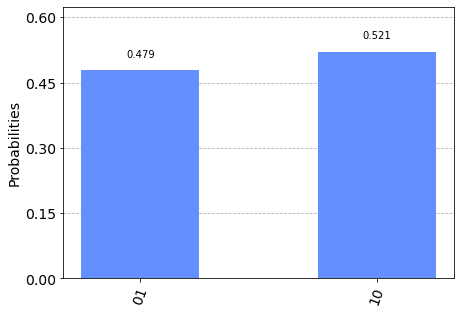

In [7]:
q = QuantumRegister(3,'q')
c = ClassicalRegister(2,'c')
qc1 = QuantumCircuit(q,c)

initial_state = [0,1]   # Define initial_state as |1> 
qc1.initialize(initial_state, 2) # Apply initialisation operation to the 2th qubit

qc1.h(q[0])
qc1.cnot(q[0],q[1])
qc1.x(q[1])

qc1.barrier()

qc1.cx(q[0],q[2])
qc1.cx(q[1],q[2])
qc1.cx(q[2],q[0])

qc1.measure(q[0],c[0])
qc1.measure(q[1],c[1])

counts = execute(qc1, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()
plot_histogram(counts)

The circuit above can be see clearly below. After apply X-gate to our initial state (Bell's state), I use another qubit (2nd quibt, ancilla) and 2 CNOT-gate with q_0 as the control, q_2 as the target and q_1 as the control, q_2 as the target to check the parity. 

With 2nd qubit being initialized as $\ket{1}$, if the state of q_0 and q_1 is the correct state which are $\ket{01}$ and $\ket{10}$, the 2nd qubit will become $\ket{0}$ and the third CNOT-gate (fixing the error) will take no action. 

However, if the state of q_0 and q_1 is the incorrect state which are $\ket{00}$ and $\ket{11}$, 2nd qubit state will remain as $\ket{1}$, then the third CNOT-gate will take action and turn the state $\ket{00}$ and $\ket{11}$ to the correct state

In [8]:
qc1.draw()

┌───┐                  ░           ┌───┐   ┌─┐
q_0: ───────┤ H ├─────────■────────░───■───────┤ X ├───┤M├
            └───┘       ┌─┴─┐┌───┐ ░   │       └─┬─┘┌─┐└╥┘
q_1: ───────────────────┤ X ├┤ X ├─░───┼────■────┼──┤M├─╫─
     ┌─────────────────┐└───┘└───┘ ░ ┌─┴─┐┌─┴─┐  │  └╥┘ ║ 
q_2: ┤ initialize(0,1) ├───────────░─┤ X ├┤ X ├──■───╫──╫─
     └─────────────────┘           ░ └───┘└───┘      ║  ║ 
c: 2/════════════════════════════════════════════════╩══╩═
                                                     1  0

#### Problem when applying to 2 X-gate to our initial state

When apply 2 X-gate to both q_0 and q_1, we can breakdown into 2 steps. 

* First, we apply X-gate to q_0 then our state become  $\frac{1}{\sqrt{2}}\ket{01} + \frac{1}{\sqrt{2}}\ket{10}$, we can use the bit-flip code above to detect and fix the error. 
* Second, we apply X-gate to q_1 which make our state turn back to our initial state $\frac{1}{\sqrt{2}}\ket{00} + \frac{1}{\sqrt{2}}\ket{11}$. 
However, we can not apply the same method (bit-flip code) above. Because in the method above, we let the **even as incorrect state** $\ket{00}$ and $\ket{11}$ and the **odd as correct state** $\ket{01}$ and $\ket{10}$ which is **opposite** in this case (when applying the X-gate to q_1 we retrieve the original state $\frac{1}{\sqrt{2}}\ket{00} + \frac{1}{\sqrt{2}}\ket{11}$ )  .

Therefore, I add another ancilla qubit q_3 with the state $\ket{0}$ to perform the parity detect and fix the incorrect state with even $\ket{00}$ and $\ket{11}$ as **correct state** and the odd $\ket{01}$ and $\ket{10}$ as **incorrect state**

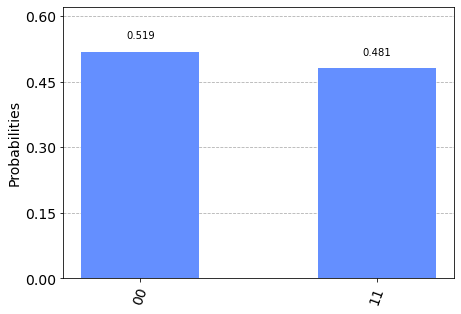

In [9]:
q = QuantumRegister(4,'q')
c = ClassicalRegister(2,'c')
qc2 = QuantumCircuit(q,c)

initial_state = [0,1]   # Define initial_state as |1> 
qc2.initialize(initial_state, 2) # Apply initialisation operation to the 2th qubit

qc2.h(q[0])
qc2.cnot(q[0],q[1])
qc2.x(q[1])
qc2.x(q[0])

qc2.barrier()

qc2.cx(q[0],q[2])
qc2.cx(q[1],q[2])
qc2.cx(q[2],q[0])

qc2.barrier()

qc2.cx(q[0],q[3])
qc2.cx(q[1],q[3])
qc2.cx(q[3],q[0])

qc2.measure(q[0],c[0])
qc2.measure(q[1],c[1])
counts = execute(qc2, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()
plot_histogram(counts)

In [10]:
qc2.draw()

┌───┐            ┌───┐ ░           ┌───┐ ░           ┌───┐   ┌─┐
q_0: ───────┤ H ├─────────■──┤ X ├─░───■───────┤ X ├─░───■───────┤ X ├───┤M├
            └───┘       ┌─┴─┐├───┤ ░   │       └─┬─┘ ░   │       └─┬─┘┌─┐└╥┘
q_1: ───────────────────┤ X ├┤ X ├─░───┼────■────┼───░───┼────■────┼──┤M├─╫─
     ┌─────────────────┐└───┘└───┘ ░ ┌─┴─┐┌─┴─┐  │   ░   │    │    │  └╥┘ ║ 
q_2: ┤ initialize(0,1) ├───────────░─┤ X ├┤ X ├──■───░───┼────┼────┼───╫──╫─
     └─────────────────┘           ░ └───┘└───┘      ░ ┌─┴─┐┌─┴─┐  │   ║  ║ 
q_3: ──────────────────────────────░─────────────────░─┤ X ├┤ X ├──■───╫──╫─
                                   ░                 ░ └───┘└───┘      ║  ║ 
c: 2/══════════════════════════════════════════════════════════════════╩══╩═
                                                                       1  0

#### The final  solution to the bit-flip error
After checking all possible case, I create a function to detect the bit-flip and fix it. After checking all possible case, I create a function to detect the bit-flip and fix it, the function give us the choice to choose which qubit and ancilla qubit we will work with.

In [11]:
def bit_flip_error(quantum_circuit,qubit,ancilla):    
    quantum_circuit.x(q[qubit])
    quantum_circuit.cx(q[0],q[ancilla])
    quantum_circuit.cx(q[1],q[ancilla])
    quantum_circuit.cx(q[ancilla],q[0])

### 5. Sign-flip error
The bit-flip code is the error when we apply the Z-gate to the circuit and the result is opposite phase to our expected value.

**Example**: When we apply the X-gate to qubit with state $\frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}$, the expected value is state $\frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}$ but the error may occured and our result remains state $\frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}$

According to the task, our initial state is a bell state which is: $\frac{1}{\sqrt{2}}\ket{00} + \frac{1}{\sqrt{2}}\ket{11}$
If there is no noise and errors in our system, when we apply Z-gate to one of the two qubits, we should get the state: $\frac{1}{\sqrt{2}}\ket{00} - \frac{1}{\sqrt{2}}\ket{11}$. However due to the noise, we can get state $\frac{1}{\sqrt{2}}\ket{00} + \frac{1}{\sqrt{2}}\ket{11}$

If we implement 2 H-gate to each of the qubit in the circuit, the state: $\frac{1}{\sqrt{2}}\ket{00} - \frac{1}{\sqrt{2}}\ket{11}$ will become $\frac{1}{\sqrt{2}}\ket{++} - \frac{1}{\sqrt{2}}\ket{--}$ (**correct state**) while the state $\frac{1}{\sqrt{2}}\ket{00} + \frac{1}{\sqrt{2}}\ket{11}$ become $\frac{1}{\sqrt{2}}\ket{++} + \frac{1}{\sqrt{2}}\ket{--} $(**incorrect state**)

As $\ket{+} = \frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}$ and $\ket{-} = \frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}$.

Therefore, 
* $\frac{1}{\sqrt{2}}\ket{++} + \frac{1}{\sqrt{2}}\ket{--} = \frac{1}{\sqrt{2}}( (\frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}) \otimes (\frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}) ) + \frac{1}{\sqrt{2}}( (\frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}) \otimes (\frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}) ) = \frac{1}{\sqrt{2}}\ket{00} + \frac{1}{\sqrt{2}}\ket{11} $

* $\frac{1}{\sqrt{2}}\ket{++} - \frac{1}{\sqrt{2}}\ket{--} = \frac{1}{\sqrt{2}}( (\frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}) \otimes (\frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}) ) - \frac{1}{\sqrt{2}}( (\frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}) \otimes (\frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}) ) = \frac{1}{\sqrt{2}}\ket{01} + \frac{1}{\sqrt{2}}\ket{10} $

We can easily detect and fix the error by using parity check and ancilla qubit which is the exact same mechanism in the bit-flip code.

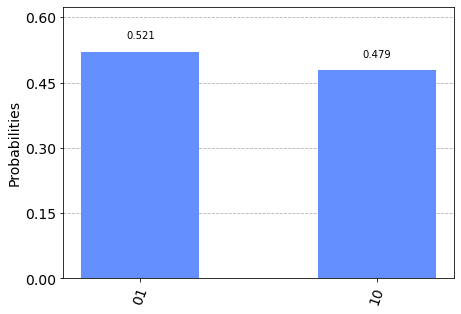

In [12]:
q = QuantumRegister(2,'q')
c = ClassicalRegister(2,'c')
qc3 = QuantumCircuit(q,c)

qc3.h(q[0])
qc3.cnot(q[0],q[1])

qc3.z(q[1])

qc3.h(q[0])
qc3.h(q[1])

qc3.measure(q[0],c[0])
qc3.measure(q[1],c[1])

counts = execute(qc3, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

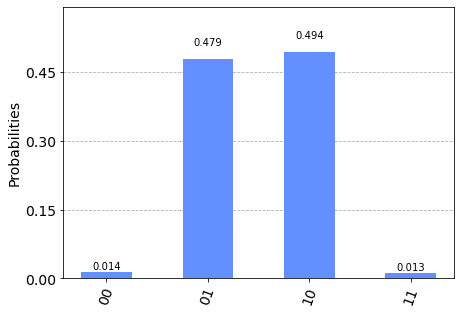

In [13]:
counts = execute(qc3, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()
plot_histogram(counts)

To fix the error cause by the noise, we can easily recoginze that by performing a parity check with an ancilla qubit (the parity of **correct state**: $\ket{01}$ and $\ket{10}$ are odd and the **incorrect state**:  $\ket{00}$ and $\ket{11}$ are even), we can define whether the errors are occured and fixed it with the circuit belowed.

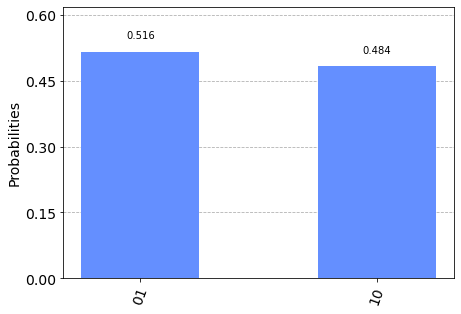

In [14]:
q = QuantumRegister(3,'q')
c = ClassicalRegister(2,'c')
qc4 = QuantumCircuit(q,c)

initial_state = [0,1]   # Define initial_state as |1> 
qc4.initialize(initial_state, 2) # Apply initialisation operation to the 2th qubit

qc4.h(q[0])
qc4.cnot(q[0],q[1])

qc4.z(q[1])

qc4.barrier()

qc4.h(q[0])
qc4.h(q[1])

qc4.barrier()

qc4.cx(q[0],q[2])
qc4.cx(q[1],q[2])
qc4.cx(q[2],q[0])

qc4.measure(q[0],c[0])
qc4.measure(q[1],c[1])

counts = execute(qc4, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()
plot_histogram(counts)

In [15]:
qc4.draw()

┌───┐                  ░ ┌───┐ ░           ┌───┐   ┌─┐
q_0: ───────┤ H ├─────────■────────░─┤ H ├─░───■───────┤ X ├───┤M├
            └───┘       ┌─┴─┐┌───┐ ░ ├───┤ ░   │       └─┬─┘┌─┐└╥┘
q_1: ───────────────────┤ X ├┤ Z ├─░─┤ H ├─░───┼────■────┼──┤M├─╫─
     ┌─────────────────┐└───┘└───┘ ░ └───┘ ░ ┌─┴─┐┌─┴─┐  │  └╥┘ ║ 
q_2: ┤ initialize(0,1) ├───────────░───────░─┤ X ├┤ X ├──■───╫──╫─
     └─────────────────┘           ░       ░ └───┘└───┘      ║  ║ 
c: 2/════════════════════════════════════════════════════════╩══╩═
                                                             1  0

After correct the result, we add another 2 H-gate to retrieve the original wanted state: $\frac{1}{\sqrt{2}}\ket{00} - \frac{1}{\sqrt{2}}\ket{11}$

In [16]:
q = QuantumRegister(3,'q')
c = ClassicalRegister(2,'c')
qc5 = QuantumCircuit(q,c)

initial_state = [0,1]   # Define initial_state as |1> 
qc5.initialize(initial_state, 2) # Apply initialisation operation to the 2th qubit

qc5.h(q[0])
qc5.cnot(q[0],q[1])

qc5.z(q[1])

qc5.barrier()

qc5.h(q[0])
qc5.h(q[1])

qc5.barrier()

qc5.cx(q[0],q[2])
qc5.cx(q[1],q[2])
qc5.cx(q[2],q[0])

qc5.barrier()

qc5.h(q[0])
qc5.h(q[1])

statevector_backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc5,statevector_backend,noise_model=noise_model).result().get_statevector()
print(final_state)

[ 7.07106781e-01-1.73191211e-16j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j -7.07106781e-01+1.73191211e-16j
  1.06049031e-32+8.65956056e-17j  6.84227766e-49+0.00000000e+00j
 -6.84227766e-49+0.00000000e+00j -1.06049031e-32-8.65956056e-17j]


#### Problem when applying to 2 Z-gate to our initial state

When apply 2 Z-gate to both q_0 and q_1, we can breakdown into 2 steps. 

* First, we apply Z-gate to q_0 then our state become  $\frac{1}{\sqrt{2}}\ket{00} - \frac{1}{\sqrt{2}}\ket{11}$, we can use the sign-flip code above to detect and fix the error. 
* Second, we apply Z-gate to q_1 which make our state turn back to our initial state $\frac{1}{\sqrt{2}}\ket{00} + \frac{1}{\sqrt{2}}\ket{11}$. 
We can easily detect and fix the error by applying H-gates to all quibts, use parity check and ancilla qubit which is the exact same mechanism in the bit-flip code. 

If we implement 2 H-gate to each of the qubit in the circuit, the state: $\frac{1}{\sqrt{2}}\ket{00} + \frac{1}{\sqrt{2}}\ket{11}$ will become $\frac{1}{\sqrt{2}}\ket{++} + \frac{1}{\sqrt{2}}\ket{--}$ (**correct state**) while the state $\frac{1}{\sqrt{2}}\ket{00} - \frac{1}{\sqrt{2}}\ket{11}$ become $\frac{1}{\sqrt{2}}\ket{++} - \frac{1}{\sqrt{2}}\ket{--} $(**incorrect state**)

As $\ket{+} = \frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}$ and $\ket{-} = \frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}$.

Therefore, 
* $\frac{1}{\sqrt{2}}\ket{++} + \frac{1}{\sqrt{2}}\ket{--} = \frac{1}{\sqrt{2}}( (\frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}) \otimes (\frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}) ) + \frac{1}{\sqrt{2}}( (\frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}) \otimes (\frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}) ) = \frac{1}{\sqrt{2}}\ket{00} + \frac{1}{\sqrt{2}}\ket{11} $

* $\frac{1}{\sqrt{2}}\ket{++} - \frac{1}{\sqrt{2}}\ket{--} = \frac{1}{\sqrt{2}}( (\frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}) \otimes (\frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}) ) - \frac{1}{\sqrt{2}}( (\frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}) \otimes (\frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}) ) = \frac{1}{\sqrt{2}}\ket{01} + \frac{1}{\sqrt{2}}\ket{10} $


Therefore, I add another ancilla qubit q_3 with the state $\ket{0}$ to perform the parity detect and fix the incorrect state with even $\ket{00}$ and $\ket{11}$ as **correct state** and the odd $\ket{01}$ and $\ket{10}$ as **incorrect state**

In [17]:
q = QuantumRegister(4,'q')
c = ClassicalRegister(2,'c')
qc6 = QuantumCircuit(q,c)

initial_state = [0,1]   # Define initial_state as |1> 
qc6.initialize(initial_state, 2) # Apply initialisation operation to the 2th qubit

qc6.h(q[0])
qc6.cnot(q[0],q[1])

qc6.z(q[0])
qc6.z(q[1])

qc6.barrier()

qc6.h(q[0])
qc6.h(q[1])

qc6.barrier()

qc6.cx(q[0],q[2])
qc6.cx(q[1],q[2])
qc6.cx(q[2],q[0])

qc6.barrier()

qc6.h(q[0])
qc6.h(q[1])

qc6.barrier()

qc6.h(q[0])
qc6.h(q[1])

qc6.barrier()

qc6.cx(q[0],q[3])
qc6.cx(q[1],q[3])
qc6.cx(q[3],q[0])

qc6.barrier()

qc6.h(q[0])
qc6.h(q[1])

statevector_backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc6,statevector_backend,noise_model=noise_model).result().get_statevector()
print(final_state)

[-1.06049031e-32+1.29872607e-48j  0.00000000e+00-1.29872607e-48j
  0.00000000e+00-1.29872607e-48j -1.06049031e-32+1.29872607e-48j
  1.06049031e-32+8.65956056e-17j -1.06049031e-32+0.00000000e+00j
 -1.06049031e-32+0.00000000e+00j  1.06049031e-32+8.65956056e-17j
  3.18147094e-32+8.65956056e-17j -1.06049031e-32+0.00000000e+00j
 -1.06049031e-32+0.00000000e+00j  3.18147094e-32+8.65956056e-17j
  7.07106781e-01-3.46382422e-16j  0.00000000e+00+8.65956056e-17j
  0.00000000e+00+8.65956056e-17j  7.07106781e-01-3.46382422e-16j]


In [18]:
qc6.draw()

┌───┐            ┌───┐ ░ ┌───┐ ░           ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
q_0: ───────┤ H ├─────────■──┤ Z ├─░─┤ H ├─░───■───────┤ X ├─░─┤ H ├─░─┤ H ├─░─»
            └───┘       ┌─┴─┐├───┤ ░ ├───┤ ░   │       └─┬─┘ ░ ├───┤ ░ ├───┤ ░ »
q_1: ───────────────────┤ X ├┤ Z ├─░─┤ H ├─░───┼────■────┼───░─┤ H ├─░─┤ H ├─░─»
     ┌─────────────────┐└───┘└───┘ ░ └───┘ ░ ┌─┴─┐┌─┴─┐  │   ░ └───┘ ░ └───┘ ░ »
q_2: ┤ initialize(0,1) ├───────────░───────░─┤ X ├┤ X ├──■───░───────░───────░─»
     └─────────────────┘           ░       ░ └───┘└───┘      ░       ░       ░ »
q_3: ──────────────────────────────░───────░─────────────────░───────░───────░─»
                                   ░       ░                 ░       ░       ░ »
c: 2/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«               ┌───┐ ░ ┌───┐
«q_0: ──■───────┤ X ├─░─┤ H ├
«       │       └─┬─┘ ░ ├───┤
«q_1: ──┼────■────┼───░─┤ H ├
«       │    │    │   ░ └───┘
«q_2: ──┼────┼────┼───░──────
«     ┌─┴─┐┌─┴─┐  │   ░      
«q_3: ┤ X ├┤ X ├──■───░──────
«     └───┘└───┘      ░      
«c: 2/═══════════════════════
«

#### The final  solution to the sign-flip error
After checking all possible case, I create a function to detect the bit-flip and fix it, the function give us the choice to choose which qubit and ancilla qubit we will work with.

In [19]:
def sign_flip_error(quantum_circuit,qubit,ancilla): 
    quantum_circuit.z(q[qubit])
    quantum_circuit.h(q[0])
    quantum_circuit.h(q[1])
    quantum_circuit.cx(q[0],q[ancilla])
    quantum_circuit.cx(q[1],q[ancilla])
    quantum_circuit.cx(q[ancilla],q[0])
    quantum_circuit.h(q[0])
    quantum_circuit.h(q[1])

### 7. When applying Z-gate and X-gate together 

When apply 2 X-gate and Z-gate to two distinct qubits, we can breakdown into 2 steps. 

* First, we apply X-gate to q_0 then our state become  $\frac{1}{\sqrt{2}}\ket{01} + \frac{1}{\sqrt{2}}\ket{10}$, we can use the bit-flip code above to detect and fix the error. 
* Second, we apply Z-gate to q_1 which make our state become $\frac{1}{\sqrt{2}}\ket{01} - \frac{1}{\sqrt{2}}\ket{10}$ with the probability of existing the error state $\frac{1}{\sqrt{2}}\ket{01} + \frac{1}{\sqrt{2}}\ket{10}$ .
Using the same approach when doing sign-flip code above, after applying H-gate to 2 quibts, the **correct state** $\frac{1}{\sqrt{2}}\ket{01} - \frac{1}{\sqrt{2}}\ket{10}$ become $\frac{1}{\sqrt{2}}\ket{+-} - \frac{1}{\sqrt{2}}\ket{-+}$ and the **incorrect state** $\frac{1}{\sqrt{2}}\ket{01} + \frac{1}{\sqrt{2}}\ket{10}$ become $\frac{1}{\sqrt{2}}\ket{+-} + \frac{1}{\sqrt{2}}\ket{-+}$  .

As $\ket{+} = \frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}$ and $\ket{-} = \frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}$.

Therefore, 
* $\frac{1}{\sqrt{2}}\ket{+-} - \frac{1}{\sqrt{2}}\ket{-+} = \frac{1}{\sqrt{2}}( (\frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}) \otimes (\frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}) ) - \frac{1}{\sqrt{2}}( (\frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}) \otimes (\frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}) ) = \frac{1}{\sqrt{2}}\ket{10} - \frac{1}{\sqrt{2}}\ket{01} $

* $\frac{1}{\sqrt{2}}\ket{+-} + \frac{1}{\sqrt{2}}\ket{-+} = \frac{1}{\sqrt{2}}( (\frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}) \otimes (\frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}) ) + \frac{1}{\sqrt{2}}( (\frac{1}{\sqrt{2}}\ket{0} - \frac{1}{\sqrt{2}}\ket{1}) \otimes (\frac{1}{\sqrt{2}}\ket{0} + \frac{1}{\sqrt{2}}\ket{1}) ) = \frac{1}{\sqrt{2}}\ket{00} - \frac{1}{\sqrt{2}}\ket{11} $

Therefore, I add another ancilla qubit q_3 with the state $\ket{1}$ to perform the parity detect and fix the incorrect state with odd as correct state $\ket{01}$ and $\ket{10}$ and the even $\ket{00}$ and $\ket{11}$ as incorrect state

In [20]:
q = QuantumRegister(4,'q')
c = ClassicalRegister(2,'c')
qc7 = QuantumCircuit(q,c)

initial_state = [0,1]   # Define initial_state as |1> 
qc7.initialize(initial_state, 2) # Apply initialisation operation to the 2th qubit
qc7.initialize(initial_state, 3) # Apply initialisation operation to the 2th qubit

qc7.h(q[0])
qc7.cnot(q[0],q[1])

qc7.x(q[0])
qc7.z(q[1])

qc7.barrier()

qc7.cx(q[0],q[2])
qc7.cx(q[1],q[2])
qc7.cx(q[2],q[0])

qc7.barrier()

qc7.h(q[0])
qc7.h(q[1])

qc7.barrier()

qc7.cx(q[0],q[3])
qc7.cx(q[1],q[3])
qc7.cx(q[2],q[0])

qc7.barrier()

qc7.h(q[0])
qc7.h(q[1])

statevector_backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc7,statevector_backend,noise_model=noise_model).result().get_statevector()
print(final_state)

[ 0.00000000e+00+0.00000000e+00j  7.07106781e-01-1.73191211e-16j
 -7.07106781e-01+1.73191211e-16j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
 -7.54746861e-49+0.00000000e+00j  7.54746861e-49+6.16297582e-33j
  7.54746861e-49+6.16297582e-33j -7.54746861e-49+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]


In [21]:
qc7.draw()

┌───┐            ┌───┐ ░           ┌───┐ ░ ┌───┐ ░           ┌───┐»
q_0: ───────┤ H ├─────────■──┤ X ├─░───■───────┤ X ├─░─┤ H ├─░───■───────┤ X ├»
            └───┘       ┌─┴─┐├───┤ ░   │       └─┬─┘ ░ ├───┤ ░   │       └─┬─┘»
q_1: ───────────────────┤ X ├┤ Z ├─░───┼────■────┼───░─┤ H ├─░───┼────■────┼──»
     ┌─────────────────┐└───┘└───┘ ░ ┌─┴─┐┌─┴─┐  │   ░ └───┘ ░   │    │    │  »
q_2: ┤ initialize(0,1) ├───────────░─┤ X ├┤ X ├──■───░───────░───┼────┼────■──»
     ├─────────────────┤           ░ └───┘└───┘      ░       ░ ┌─┴─┐┌─┴─┐     »
q_3: ┤ initialize(0,1) ├───────────░─────────────────░───────░─┤ X ├┤ X ├─────»
     └─────────────────┘           ░                 ░       ░ └───┘└───┘     »
c: 2/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«      ░ ┌───┐
«q_0: ─░─┤ H ├
«      ░ ├───┤
«q_1: ─░─┤ H ├
«      ░ └───┘
«q_2: ─░──────
«      ░      
«q_3: ─░──────
«      ░      
«c: 2/════════
«

## III. Final code and conclusion

After checking all possible case that can happen, I will use 2 solution (function) of bit-flip code and sign-flip code for my final code which contain all possibilities with percentage greater than 0. 

In [22]:
q = QuantumRegister(6,'q')
c = ClassicalRegister(2,'c')
qc = QuantumCircuit(q,c) # initialize circuit

initial_state = [0,1]   # Define initial_state as |1> 
qc.initialize(initial_state, 2) # Apply initialisation operation to the 2th qubit for bit-flip
qc.initialize(initial_state, 4) # Apply initialisation operation to the 2th qubit for sign-flip

x = random.randint(9) #Using random to get all possible case with percentage greater than 0

qc.h(q[0])
qc.cnot(q[0],q[1])

if(x==0):
    qc.i(q[0])
    qc.i(q[1])
elif(x==1):
    bit_flip_error(qc,0,2)
    qc.i(q[1])
elif(x==2):
    bit_flip_error(qc,1,2)
    qc.i(q[0])   
elif(x==3):
    sign_flip_error(qc,0,4)
    qc.i(q[1])
elif(x==4):
    sign_flip_error(qc,1,4)
    qc.i(q[0])
elif(x==5):
    bit_flip_error(qc,0,2)
    bit_flip_error(qc,1,3)
elif(x==6):
    sign_flip_error(qc,0,4)
    sign_flip_error(qc,1,5)
elif(x==7):
    bit_flip_error(qc,0,2)
    sign_flip_error(qc,1,4)
elif(x==8):
    bit_flip_error(qc,1,2)
    sign_flip_error(qc,0,4)
    
#qc.measure(q[0],c[0])
#qc.measure(q[1],c[1])
# run the circuit with th noise model and extract the counts
#counts = execute(qc, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()
#plot_histogram(counts)
print(x)
statevector_backend = Aer.get_backend('statevector_simulator')
final_state = execute(qc,statevector_backend,noise_model=noise_model).result().get_statevector()
print(final_state)

7
[ 0.00000000e+00+0.00000000e+00j  7.07106781e-01-1.73191211e-16j
 -7.07106781e-01+1.73191211e-16j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  7.54746861e-49+6.16297582e-33j
 -7.54746861e-49-6.16297582e-33j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.0000

## IV. Reference
[https://en.wikipedia.org/wiki/Quantum_error_correction#The_bit_flip_code][1]

[https://users.physics.ox.ac.uk/~Steane/qec/qec_ams_1.html][2]
